In [1]:
import sys
sys.path.insert(1, '/Users/linusrandud/Documents/UoM/ERP/MscDissertation/Deep-Opt')

In [2]:
import torch

from COProblems.MKP import MKP
from COProblems.QUBO import QUBO
from Models.DOAE import DOAE
from OptimAE import OptimAEHandler

In [3]:
import wandb
import matplotlib.pyplot as plt

In [4]:
wandb.init(project='Deep Optimization', tags=['MKP'])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: linusrd. Use `wandb login --relogin` to force relogin


In [5]:
# Highly recommended to keep as cpu for problems of size <= 100
device="cpu"
print(device)
device = torch.device(device)

cpu


In [6]:
prob_file_path = '../data/mkp/problems30d.txt'
fitness_file_path = '../data/mkp/fitnesses30d.txt'
problem = MKP(prob_file_path, fitness_file_path, 12, device)

This instance has 100 items and 30 dimensions
Max possible fitness for this instance: 41560.0


In [7]:
# Log problem definition (assuming it's a file)
wandb.log_artifact(prob_file_path, type='dataset')
wandb.log_artifact(fitness_file_path, type='dataset')

<Artifact run-c7b90w9y-fitnesses30d.txt>

In [8]:
import torch

from COProblems.MKP import MKP
from COProblems.QUBO import QUBO
from Models.DOAE import DOAE
from OptimAE import OptimAEHandler

# Highly recommended to keep as cpu for problems of size <= 100
# device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
# print(device)
# device = torch.device(device)

change_tolerance = 100
problem_size = 100
pop_size = 200
# problem = MKP("COProblems\\mkp\\problems30d.txt", "COProblems\\mkp\\fitnesses30d.txt", 12, device)
# problem = QUBO("COProblems\\qubo\\bqp500.txt", 0, device)

dropout_prob = 0.2
# 1000 bit QUBO l1 and l2:
# l1_coef = 0.0000025
# l2_coef = 0.0000025
# 500 bit QUBO l1 and l2:
# l1_coef = 0.000005
# l2_coef = 0.000005
# 100 bit l1 and l2
l1_coef = 0.0001
l2_coef = 0.0001
lr = 0.002
max_depth = 6
compression_ratio = 0.8
model = DOAE(problem_size, dropout_prob, device)
hidden_size = problem_size
handler = OptimAEHandler(model, problem, device)

# Log hyperparameters
wandb.config.update({
    "change_tolerance": change_tolerance,
    "problem_size": problem_size,
    "pop_size": pop_size,
    "dropout_prob": dropout_prob,
    "l1_coef": l1_coef,
    "l2_coef": l2_coef,
    "learning_rate": lr,
    "compression_ratio": compression_ratio,
    "max_depth": max_depth,
})

# Log model architecture
wandb.watch(model, log='all')

population, fitnesses = handler.generate_population(pop_size)
population, fitnesses, _, _ = handler.hillclimb(population, fitnesses, change_tolerance)
handler.print_statistics(fitnesses)

total_eval = 0
depth = 0

# Store metrics for custom plotting
mean_fitnesses = []
max_fitnesses = []
total_evaluations = []

while True:
    if depth < max_depth:
        print("Adding layer")
        hidden_size = round(hidden_size * compression_ratio)
        model.transition(hidden_size)
        depth += 1
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coef)
    print("Learning from population")
    # Learning with the entire population as a batch is technically not the best from a machine learning perspective,
    # but does not seem to have a massive impact on solution quality whilst also increasing learning speed significantly.
    handler.learn_from_population(population, optimizer, l1_coef=l1_coef, batch_size=pop_size)
    print("Optimising population")
    population, fitnesses, evaluations, done = handler.optimise_solutions(
        population, fitnesses, change_tolerance, encode=True, repair_solutions=True, deepest_only=False
    )
    handler.print_statistics(fitnesses)
    
    # Log metrics to W&B
    mean_fitness = fitnesses.mean().item()
    max_fitness = fitnesses.max().item()
    total_eval += evaluations

    mean_fitnesses.append(mean_fitness)
    max_fitnesses.append(max_fitness)
    total_evaluations.append(total_eval)

    wandb.log({
        "mean_fitness": mean_fitness,
        "max_fitness": max_fitness,
        "total_eval": total_eval,
        "depth": depth
    })
    
    print("Evaluations: {}".format(total_eval))
    
    # Uncomment lines below to print out best solution at every transition
    # best_i = torch.argmax(fitnesses)
    # print("Best solution - fitness = {}".format(fitnesses[best_i].item()))
    # print(population[best_i].tolist())
    if done:
        break

Max pop fitness: 35709.0, Mean pop fitness : 33508.44140625
Adding layer
Learning from population
Optimising population
Max pop fitness: 41129.0, Mean pop fitness : 40487.68359375
Evaluations: 50964
Adding layer
Learning from population
Optimising population
Max pop fitness: 41356.0, Mean pop fitness : 40965.66015625
Evaluations: 108154
Adding layer
Learning from population
Optimising population
Max pop fitness: 41382.0, Mean pop fitness : 41046.2734375
Evaluations: 176382
Adding layer
Learning from population
Optimising population
Max pop fitness: 41387.0, Mean pop fitness : 41115.28125
Evaluations: 263138
Adding layer
Learning from population
Optimising population
Max pop fitness: 41387.0, Mean pop fitness : 41165.4609375
Evaluations: 369179
Adding layer
Learning from population
Optimising population
Max pop fitness: 41387.0, Mean pop fitness : 41199.6796875
Evaluations: 493864
Learning from population
Optimising population
Max pop fitness: 41387.0, Mean pop fitness : 41222.94140625


KeyboardInterrupt: 

depth,▁███████████████████████████████████████
max_fitness,▁███████████████████████████████████████
mean_fitness,▁▅▇▇▇███████████████████████████████████
total_eval,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
depth,6
max_fitness,41523.0
mean_fitness,41516.01562
total_eval,59447927


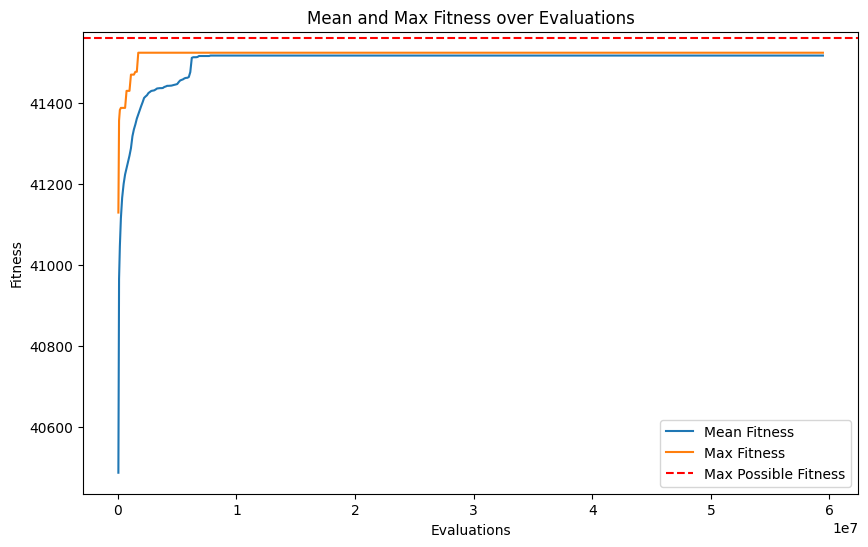

In [9]:
# Custom plot
plt.figure(figsize=(10, 6))
plt.plot(total_evaluations, mean_fitnesses, label='Mean Fitness')
plt.plot(total_evaluations, max_fitnesses, label='Max Fitness')
plt.axhline(y=problem.max_fitness, color='r', linestyle='--', label='Max Possible Fitness')
plt.xlabel('Evaluations')
plt.ylabel('Fitness')
plt.title('Mean and Max Fitness over Evaluations')
plt.legend()

# Save plot to W&B
wandb.log({"fitness_plot": wandb.Image(plt)})

# Finish the W&B run
wandb.finish()

In [ ]:
model

DOAE(
  (encoder): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=100, out_features=80, bias=True)
    (2): Tanh()
    (3): Linear(in_features=80, out_features=64, bias=True)
    (4): Tanh()
    (5): Linear(in_features=64, out_features=51, bias=True)
    (6): Tanh()
    (7): Linear(in_features=51, out_features=41, bias=True)
    (8): Tanh()
    (9): Linear(in_features=41, out_features=33, bias=True)
    (10): Tanh()
    (11): Linear(in_features=33, out_features=26, bias=True)
    (12): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=26, out_features=33, bias=True)
    (1): Tanh()
    (2): Linear(in_features=33, out_features=41, bias=True)
    (3): Tanh()
    (4): Linear(in_features=41, out_features=51, bias=True)
    (5): Tanh()
    (6): Linear(in_features=51, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=80, bias=True)
    (9): Tanh()
    (10): Linear(in_features=80, out_features=100, bias=True)

In [ ]:
model.num_layers

7

In [ ]:
model.encoder[1+(2*3):]

Sequential(
  (7): Linear(in_features=51, out_features=41, bias=True)
  (8): Tanh()
  (9): Linear(in_features=41, out_features=33, bias=True)
  (10): Tanh()
  (11): Linear(in_features=33, out_features=26, bias=True)
  (12): Tanh()
)

In [ ]:
population

tensor([[-1., -1.,  1.,  ..., -1., -1., -1.],
        [-1., -1.,  1.,  ..., -1., -1., -1.],
        [-1., -1.,  1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1.,  1.,  ..., -1., -1., -1.],
        [-1., -1.,  1.,  ..., -1., -1., -1.],
        [-1., -1.,  1.,  ..., -1., -1., -1.]])

In [ ]:
population.shape

torch.Size([200, 100])

In [10]:
population[0]

tensor([-1.,  1.,  1., -1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,
         1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.,
         1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.,  1.,
        -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,
         1., -1.,  1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1.,  1.,  1.,
        -1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,
         1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
        -1., -1.])

In [ ]:
fitnesses

tensor([41518., 41518., 41518., 41518., 41518., 41518., 41518., 41518., 41518.,
        41518., 41518., 41518., 41518., 41518., 41518., 41518., 41518., 41518.,
        41518., 41518., 41518., 41518., 41518., 41518., 41518., 41518., 41518.,
        41518., 41518., 41518., 41518., 41518., 41518., 41518., 41518., 41518.,
        41518., 41518., 41518., 41518., 41518., 41518., 41518., 41518., 41518.,
        41518., 41518., 41518., 41518., 41518., 41518., 41399., 41518., 41518.,
        41518., 41518., 41518., 41518., 41518., 41518., 41518., 41518., 41518.,
        41518., 41518., 41518., 41518., 41518., 41518., 41518., 41518., 41518.,
        41518., 41518., 41518., 41518., 41518., 41518., 41371., 41518., 41518.,
        41518., 41518., 41518., 41518., 41518., 41518., 41518., 41518., 41518.,
        41518., 41518., 41518., 41440., 41518., 41518., 41518., 41518., 41518.,
        41518., 41518., 41518., 41518., 41518., 41518., 41518., 41518., 41518.,
        41518., 41518., 41518., 41518., 

In [ ]:
evaluations

60600